________________
# Sky RMS test and contamination rate for HST images

Written by Laura Prichard, October 2019. Updated for Python 3.7 August 2020. Contamination rate added June 2021.

Takes drizzled _Hubble space Telescope_ (HST) images, with `build=True` in `Astrodrizzle` from [DrizzlePac](https://www.stsci.edu/scientific-community/software/drizzlepac.html), as inputs. Code creates a segmentation map with `photutils` for source detection.

**For RMS test:** Code measures the root-mean-squared (RMS) of the sky background within randomly placed apertures where there are no objects. Then plots a histogram, Gaussian of distribution, and averages of the RMS measurements. With additional user inputs, can determine a limiting magnitude of the image within a user-defined aperture size.

**For contamination rates:** Code places random apertures (size set by user to best match sources of interest) and determines how many have significant overlap (set by user) with objects in the segmentation map. Determines a contamination rate for sources in the input image.

For a full working example, an example drizzle of Wide Field Camera 3 (WFC3)/F336W `*flc.fits` from [MAST](https://archive.stsci.edu/) can be downloaded from Box [here](https://stsci.box.com/s/z3kgyixcmpsdqho9hlgwpx0zdubz3vs2) (`F336W_drc.fits`). Place this in the same directory as this notebook. The image was made with `build=True`, so the data and error maps are in different extensions.

**0) Import packages**

In [1]:
import numpy as np
import random
import astropy.io.fits as fits
import matplotlib.pyplot as plt

from scipy.stats import norm
from photutils import detect_sources, detect_threshold
from astropy.convolution import Gaussian2DKernel, Tophat2DKernel
from astropy.stats import gaussian_fwhm_to_sigma, sigma_clipped_stats
from astropy.visualization import SqrtStretch, ZScaleInterval
from astropy.visualization.mpl_normalize import ImageNormalize

%matplotlib inline

**1) Read in image**

If downloading the image linked above and placing it in this code directory, run the cell below, otherwise put the full path to your input drizzle.

In [2]:
# ---------------------------------------
# REQUIRED USER INPUT

# File path to drizzled output image made with build=True
file = './F336W_drc.fits'
# ---------------------------------------

# Open the drizzled image
drz = fits.open(file)

# Get header
hdr = drz[0].header

# Read in data
dat = drz[1].data

# Read in IVM/ERR maps
ivm = drz[2].data

**2) Make segmentation maps with `photutils`**

Play with the kernel width (`sigma`), size (`x_size`, `y_size`), type (`kern`) for smoothing the image. The threshold (`snr`) and number of pixels (`npix`) will determine how many objects are identified in the image.

In [3]:
def make_seg_map(data, sigma=3.0, x_size=3, y_size=3, kern='gauss', snr=3.0, npix=3):
    """For input science image data, create a kernel with user input size (x_size,y_size),
    width (sigma) and type (kern, options 'gauss' or 'tophat'). Set a threshold using 
    photutils.detect_threshold and user input S/N (snr). Create a segmentation map of 
    image with the threshold and kernel as inputs, and the number of continuous pixels 
    for an object to be considered real (npix)."""
    
    # Create a kernel
    # sigma = sig * gaussian_fwhm_to_sigma    # If providing a FWHM instead of sigma, FWHM = 3.
    if kern=='gauss': kernel = Gaussian2DKernel(sigma, x_size=x_size, y_size=y_size)
    elif kern=='tophat': kernel = Tophat2DKernel(sigma*2.5, x_size=int(x_size*3), y_size=int(y_size*3))
    else: print("ERROR: Kernel should be either 'gauss' or 'tophat'")
    kernel.normalize()

    # Determine a detection threshold
    threshold = detect_threshold(data, nsigma=snr)
    
    # Create a segemenation map
    segm = detect_sources(data, threshold, npixels=npix, filter_kernel=kernel)
    return segm, kernel

In [4]:
# Create a segmenation map of the image
segm, kern = make_seg_map(dat, sigma=3.0, snr=3.0, npix=20)

In [5]:
# Count the number of sources
print('Sources in image: {}'.format(segm.nlabels))

Sources in image: 2319


**3) Plot & check image, segmentation maps, and IVM/ERR array**

Check to see if the segmentation map seems to be picking up real objects by comparing it with the image. Check the footprint of the IVM image, this shows where data are without relying on NaNs or zeros in the image itself which can appear throughout.

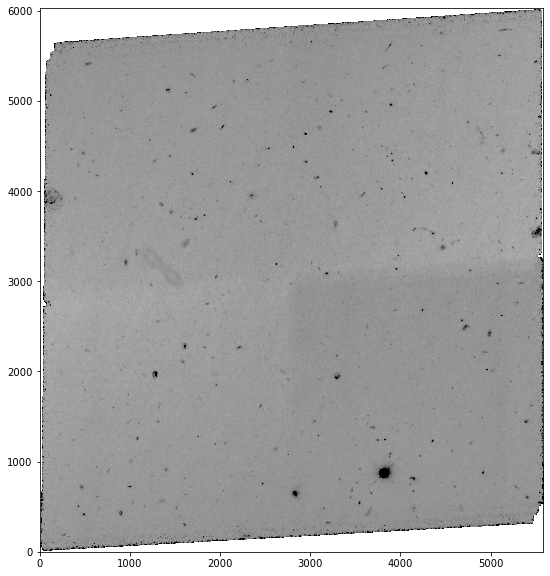

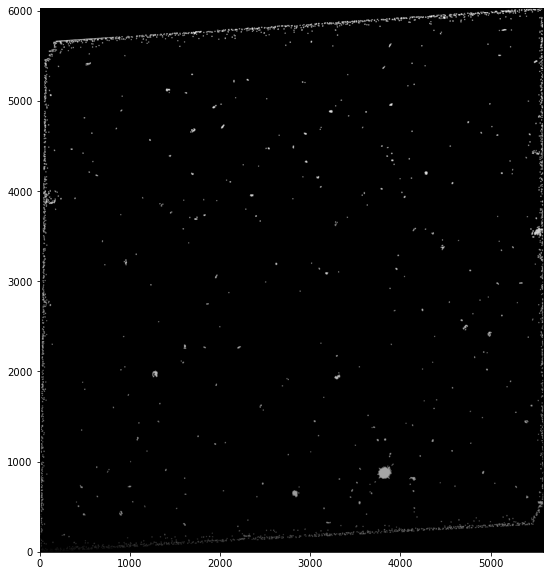

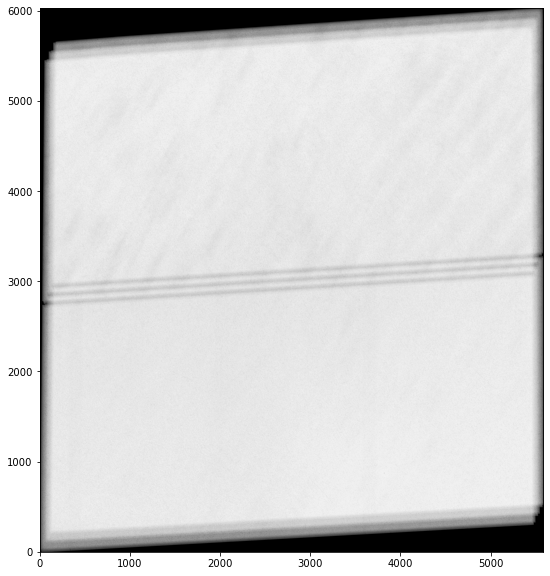

In [6]:
# Plot image
plt.figure(figsize=(10, 10))
# Get image limits for plotting
zscale = ZScaleInterval()
z1, z2 = zscale.get_limits(dat)
plt.imshow(dat, origin='lower', cmap='Greys', vmin=z1, vmax=z2)
plt.show()

# Plot segmenation map
plt.figure(figsize=(10, 10))
imnorm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(segm.data, origin='lower', cmap='Greys_r', norm=imnorm)
plt.show()

# Plot error map
plt.figure(figsize=(10, 10))
imnorm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(ivm, origin='lower', cmap='Greys_r', norm=imnorm)
plt.show()

# RMS Measurements

**4) Measure sky RMS (`mode='rms'`)**

Determine an array of RMS measurements from a number (`repeat`) of randomly placed square apertures of pixel size (`ap_size`) on the image, using the the error map to get the image footprint, and the segmentation map to identify where objects are.

In [26]:
def sky_rms_lowz(data, err, segm, ap_size=50, repeat=1000, mode='rms', npix=15):
    '''Function to determine the RMS of the sky background of drizzled images a number of times 
    (``mode='rms'``, default) OR to determine the chance of contamination in an image (``mode='lowz'``).
    Requires an input image (``data``), corresponding error/IVM map (``err``, where outside the data 
    footprint =0), and segmentation map (``segm``, sky=0). Can set the aperture size (``ap_size`` in 
    pixels) and the number of reptitions (``repeat``). 
    
    For ``mode='rms'``: Checks that the randomly placed apertures are in the image footprint and 
    not on an object. Returns a list of RMS values from background of image.
    
    For ``mode='lowz'``: Checks that the randomly placed apertures are in the image footprint and 
    counts whether it lands on an object (contaminated, ``bad``) or not (clean, ``good``). Returns 
    a contamination rate for an image (``bad/good``). Set number of source pixels in the randomly 
    placed aperture to be considered contamination (``npix``, default 15).'''

    # Determines data size
    y, x = data.shape
    random.seed(16483)

    # Set starting values
    good=0
    bad=0
    rms_vals = []
    
    # Loop to randomly place apertures on the image
    n=0
    g=0
    while good<repeat:
        
        # Get a random placement of aperture on the drizzle image
        start = [random.randint(0,(y-ap_size)), random.randint(0,(x-ap_size))]
        
        # Counter
        if (good%round(repeat/10)==0): 
            if n==0: 
                if mode=='rms': print('Measuring sky RMS of image')
                elif mode=='lowz': print('Measuring contamination rate image')
                n+=1
            if g==0:
                print('{} good apertures complete'.format(good))
                g+=1

        # Define the pixels over this image of the err map (to check if in the image footprint)
        err_pix = err[start[0]:start[0]+ap_size, start[1]:start[1]+ap_size]

        # Get segmentation cut out  
        seg_pix = segm[start[0]:start[0]+ap_size, start[1]:start[1]+ap_size]

        # If calculating RMS, check there are no objects in footprint
        if mode=='rms':
            # If the aperture is within the footprint and has no objects in, take and store the RMS of the data
            if np.all(err_pix != 0) and np.all(seg_pix == 0):

                # Set the data in the aperture
                ap_dat = data[start[0]:start[0]+ap_size, start[1]:start[1]+ap_size]

                # Determine the RMS within the sky aperture
                rms = np.sqrt(np.nanmean(ap_dat**2))
                rms_vals.append(rms)

                # Counts the number of good apertures placed, looop runs iuntil this number reaches the repeat keyword
                good+=1
                g=0

            else:
                bad+=1

        # If checking for low-z contamination, check for object overlap
        if mode=='lowz':
            # If the aperture is within the footprint and has no objects in, take and store the RMS of the data
            if np.all(err_pix != 0) and (np.count_nonzero(seg_pix)>npix):
                bad+=1   # There is overlap
            else:
                good+=1  # There is no overlap
                g=0

    print('Good apertures: {}, bad apertures: {}'.format(good, bad))
    
    if mode=='rms': return rms_vals
    if mode=='lowz': 
        print('Contamination (with {} pixel overlap) rate in {} pix width aperture: {} ({}%)'.format(npix, ap_size, bad/good, (bad/good)*100))
        return bad/good
    

In [16]:
# Get array of RMS values measured from image
ap_size = 50       # In pixels: e.g. 1.5" RMS aperture/0.03" pixel scale = 50 pixels
repeat = 1000      # Large number of repeats for more confidence

rms_vals = sky_rms_lowz(dat, ivm, segm.data, ap_size=ap_size, repeat=repeat, mode='rms')

Measuring sky RMS of image
0 good apertures complete
100 good apertures complete
200 good apertures complete
300 good apertures complete
400 good apertures complete
500 good apertures complete
600 good apertures complete
700 good apertures complete
800 good apertures complete
900 good apertures complete
Good apertures: 1000, bad apertures: 136


**5) Plot histogram of RMS values**

Plot histogram and Gaussian distribution of RMS values, and determine statistics.

In [17]:
def plot_hist_gauss(rms, label='', col='b', sig_clip=3.0, nbins='auto', normpdf=True):
    """Determines sigma-clipped stats (sig_clip) of the input values, plots a histogram 
    of the values either normalized (normpdf=True) or not with user-defined bins (nbins, default 'auto'). 
    Then overplots a Gaussian and mean line (with value given) all of user-specified color string (col) 
    and label (label)."""
    
    # Sigma-clipped stats for best fit of data
    mu, med, std = sigma_clipped_stats(rms, sigma=sig_clip)
    print("{}-sigma-clipped stats: mu={:.6f}, med={:.6f}, std={:.6f}".format(sig_clip, mu, med, std))

    # Determine the histogram of the RMS values
    if normpdf==True: n, bins, patches = plt.hist(rms, bins=nbins, density=True, stacked=True, histtype='step', label=r"{}, avg. RMS: %.6f".format(label) % (mu), color=col)
    else: n, bins, patches = plt.hist(rms, bins=nbins, density=False, histtype='step', label=r"{}, avg. RMS: %.6f".format(label) % (mu), color=col)
    
    # Add a 'best fit' Gaussian line
    y = norm.pdf(bins, mu, std)
    if normpdf==True: 
        l = plt.plot(bins, y, color=col, ls='--', linewidth=1.5)
        plt.ylabel('Density')
    else:
        #Scale the Gaussian if not normalized
        dx = bins[1]-bins[0]
        scale = len(rms)*dx
        l = plt.plot(bins, y*scale, color=col, ls='--', linewidth=1.5)
        plt.ylabel('Frequency')
    
    # Plot the mean as a vertical line
    plt.axvline(x=mu, color=col)
    plt.xlabel('RMS of Sky Background')
    
    plt.legend()
    
    return mu, med, std

3.0-sigma-clipped stats: mu=0.000389, med=0.000386, std=0.000029


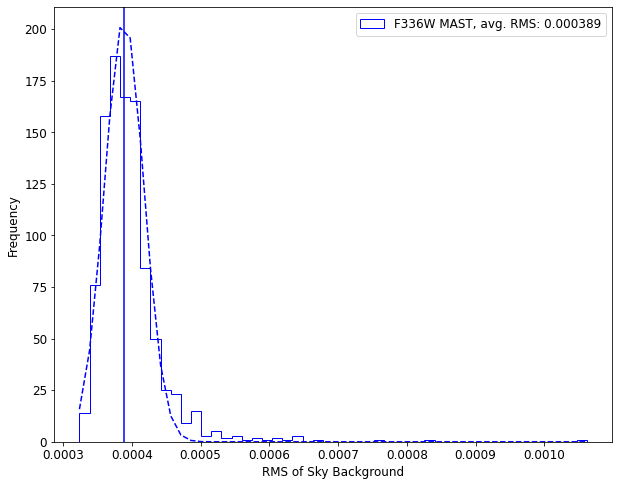

In [18]:
# Set plot params
plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': 12})

# Plot RMS histograms, gaussians, and get averages
mu, med, std = plot_hist_gauss(rms_vals, label='F336W MAST', col='b', sig_clip=3.0, nbins=50, normpdf=False)

# # Save plot
# plt.tight_layout()
# plt.savefig("sky_rms_hist.png", dpi=200)

**6) Optional: Convert the average RMS to a limiting magnitude**

The following requires more user input depending on the filter of the image and desired aperture size for your photometry. First determine the AB magnitude zeropoint of the filter (e.g. from the [WFC3 cal webpages](https://www.stsci.edu/hst/instrumentation/wfc3/data-analysis/photometric-calibration/uvis-photometric-calibration), [ACS page](https://www.stsci.edu/hst/instrumentation/acs/data-analysis/zeropoints) or other instrument), get the pixel scale in arcsec from the drizzle header (this may have a different keyword), and set the desired aperture size (diameter of a circular aperture) for your photometry in arcsec.

NOTE: If using WFC3/UVIS data downloaded from MAST from ~December 2020 onwards, you will need to use the new [time-dependent photometry](https://www.stsci.edu/hst/instrumentation/wfc3/data-analysis/photometric-calibration/uvis-photometric-calibration). The link contains notebooks for determining zeropoints for your data.

In [20]:
# ---------------------------------------
# REQUIRED USER INPUTS

# Zeropoint AB magnitude for F336W
zeropoint = 24.708

# Set image pixel scale in arcsec
pix_scale = 0.03

# Set aperture size (diameter) in arcsec
ap_arcsec = 0.2

# Set sigma for magnitude confidence level depth, e.g. mAB~27 mag at 5-sigma
sigmag = 5.
# ---------------------------------------

# Calculate the circular aperture size in pixels
ap_area_pix = np.pi*(0.5*(ap_arcsec/pix_scale))**2

# Determine the avg. RMS sky background in the aperture 
ap_rms_sum = med*ap_area_pix

# Determine the magnitude of the average background RMS in the aperture size
ap_rms_sum_mag = -2.5*np.log10(ap_rms_sum) + zeropoint

print('Limiting AB magnitude in a {} arcsec diameter circular aperture: {:.2f}'.format(ap_arcsec, ap_rms_sum_mag))

# Determine the sigmag-level confidence detection magnitude
sumsig = sigmag*ap_rms_sum

# Determine the magnitude of the average background RMS in the aperture size
sumsig_mag = -2.5*np.log10(sumsig) + zeropoint

print('AB mag depth in a {} arcsec diameter circular aperture: {:.2f} @ {}-sigma'.format(ap_arcsec, sumsig_mag, sigmag))


Limiting AB magnitude in a 0.2 arcsec diameter circular aperture: 29.38
AB mag depth in a 0.2 arcsec diameter circular aperture: 27.64 @ 5.0-sigma


# Contamination Rates of Images

**7) Measure contamination rates (`mode='lowz'`)**

For contamination rates, `ap_size` should be the average size of your targets for which you want to determine the chance of overlap with other sources. The number of pixel overlap for an aperture to be considered contaminated (`npix`) can be set to best suit the survey (default 15). This can be repeated a large number of times to get accurate contamination-rate values.

In [29]:
# Set the aperture sizes, number of repetitions and x, y parameters
ap_size = 17        # In pixels: e.g. 0.5" avg. source size/0.03" pixel scale ~ 17 pixels
repeat = 10000       # Large number of repeats for more confidence
npix = 15           # Number of pixels overlap to be considered contamination

# Get RMS of different images
cont = sky_rms_lowz(dat, ivm, segm.data, ap_size=ap_size, repeat=repeat, mode='lowz', npix=npix)


Measuring contamination rate image
0 good apertures complete
1000 good apertures complete
2000 good apertures complete
3000 good apertures complete
4000 good apertures complete
5000 good apertures complete
6000 good apertures complete
7000 good apertures complete
8000 good apertures complete
9000 good apertures complete
Good apertures: 10000, bad apertures: 116
Contamination (with 15 pixel overlap) rate in 17 pix width aperture: 0.0116 (1.16%)
